### Training
The prepared patches are used for the training and validation set. Note, that for this repository only a small subset to visualize the patch input, is saved for training the model.The target set might need downsampling (depending of which preprocessing step was choosen, this is an historically built step, otherwise only creating a binary dataset is necessary) and creating a binary target, wet or dry, from precipitation intensities. The input is channel-wise normalized with the prepared functions. Then, the skewed dataset is adapted, by eliminating a certain share of only dry patches (hyper-parameter). Finally, the model is trained with defined hyperparameters and the prepared training and validation subset.

In [1]:
import numpy as np
import tensorflow.keras.layers as layers
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import sklearn
from keras import backend as K
import keras
import tensorflow as tf
from livelossplot import PlotLossesKeras
from tqdm import tqdm
import sys
import os
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
import training_modules

/bg/fast/env_wiegels-r/mambaforge/envs/tf_26/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# GPU avilability
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  []


2024-01-10 11:43:42.847632: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-01-10 11:43:42.847833: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-10 11:43:42.847858: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (owl02intel): /proc/driver/nvidia/version does not exist


In [4]:
# open datasets
# patches for training and validation
patches = xr.open_zarr('../data/patches.zarr')

In [8]:
img_height = 9
img_width = 9
bi_threshold = 0.05 # (mm/15min)

# from DL_data_analysis: excludes outlier
min_temp = 202.758
max_temp = 317.1550 
min_bright = 0.000000
max_bright = 101.4570

In [9]:
ds_train = patches.isel(channels = slice(0, 8), ID = slice(0, 500)).load()
ds_val = patches.isel(channels = slice(0, 8), ID = slice(500, 700)).load()

In [23]:
# devide into training and validation set
ds_input_train = np.asarray(ds_train.input)
ds_input_val = np.asarray(ds_val.input)

In [24]:
# y binary target input for training and validation
y_train = training_modules.downsampling(ds_train, th=bi_threshold)
y_val = training_modules.downsampling(ds_val, th=bi_threshold)

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.03it/s]


[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0.]]


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 41.04it/s]

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [25]:
print(ds_input_train.shape, ds_input_val.shape, y_train.shape, y_val.shape)

(1000, 9, 9, 8) (500, 9, 9, 8) (1000, 9, 9) (500, 9, 9)


In [26]:
# Normalize input
x_train = np.asarray(training_modules.normalize_train_val(ds_input_train, min_temp = min_temp, max_temp = max_temp, 
                                                          min_bright = min_bright, max_bright = max_bright))
x_val = np.asarray(training_modules.normalize_train_val(ds_input_val, min_temp = min_temp, max_temp = max_temp, 
                                                        min_bright = min_bright, max_bright = max_bright))

In [27]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1000, 9, 9, 8) (1000, 9, 9)
(500, 9, 9, 8) (500, 9, 9)


In [28]:
# throw out any patch with no rain or almost no rain (e.g. only 5 pixels of binary image with rain) # low-resolution
def reduce_low_rain(img, bi_img, threshold):
    return img[np.sum(bi_img, axis=(1,2)) > threshold]
# compare rain/no-rain ratio of datasets
print('Rain/no-rain ratio (val)', (y_val==1).sum()/(y_val>=0).sum())
print('Rain/no-rain ratio (train)', (y_train==1).sum()/(y_train>=0).sum())
#train
threshold = 0
x_train_wet = reduce_low_rain(x_train, y_train, threshold)
y_train_wet = reduce_low_rain(y_train, y_train, threshold)
#val
x_val_wet = reduce_low_rain(x_val, y_val, threshold)
y_val_wet = reduce_low_rain(y_val, y_val, threshold)

print('Rain/no-rain ratio (val)', (y_val_wet==1).sum()/(y_val_wet>=0).sum())
print('Rain/no-rain ratio (train)', (y_train_wet>=0.05).sum()/(y_train_wet>=0).sum())

Rain/no-rain ratio (val) 0.049234567901234566
Rain/no-rain ratio (train) 0.07166666666666667
Rain/no-rain ratio (val) 0.23006807430483442
Rain/no-rain ratio (train) 0.2664188351920694


In [29]:
x_val_wd, y_val_wd = training_modules.sample_set_wet_dry(0.5, x_val, x_val_wet, y_val, y_val_wet)
x_train_wd, y_train_wd = training_modules.sample_set_wet_dry(0.5, x_train, x_train_wet, y_train, y_train_wet)

In [30]:
print('VALIDATION', x_val.shape, y_val.shape, y_val_wet.shape, x_val_wd.shape, y_val_wd.shape)
print('TRAINING', x_train.shape, y_train.shape, y_train_wet.shape, x_train_wd.shape, y_train_wd.shape)

VALIDATION (500, 9, 9, 8) (500, 9, 9) (107, 9, 9) (303, 9, 9, 8) (303, 9, 9)
TRAINING (1000, 9, 9, 8) (1000, 9, 9) (269, 9, 9) (634, 9, 9, 8) (634, 9, 9)


In [31]:
print('Rain/no-rain ratio (val)', (y_val_wd==1).sum()/(y_val_wd>=0).sum())
print('Rain/no-rain ratio (train)', (y_train_wd>=0.05).sum()/(y_train_wd>=0).sum())

Rain/no-rain ratio (val) 0.10316587214276983
Rain/no-rain ratio (train) 0.1584102504186626


In [33]:
# Transformation to tensor for DL Model
# Train with selected share of dry patches:
y_train = y_train_wd
y_val = y_val_wd
x_train = x_train_wd
x_val = x_val_wd

y_train_low = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 1)
y_val_low = y_val.reshape(y_val.shape[0], y_val.shape[1], y_val.shape[2], 1)
y_train_low = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_val_low = tf.convert_to_tensor(y_val, dtype=tf.float32)


x_train0_low, x_train1_low, x_train2_low, x_train3_low, x_train4_low, x_train5_low, x_train6_low, x_train7_low = training_modules.to_tensor(x_train)
x_val0_low, x_val1_low, x_val2_low, x_val3_low, x_val4_low, x_val5_low, x_val6_low, x_val7_low = training_modules.to_tensor(x_val)

2024-01-04 18:15:25.822639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31031 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:af:00.0, compute capability: 7.0


## CNN_Sev MODEL

In [34]:
# Model Functions
def convbn(x, n_filter):
    x = tf.keras.layers.Conv2D(n_filter, kernel_size=3, padding='same',
                                     kernel_initializer=initializer,
                          )(x)
    x = tf.keras.layers.Conv2D(n_filter, kernel_size=3, padding='same',
                                     kernel_initializer=initializer,
                          )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    return x


def downsampling(x, n_filter):
    x1 = tf.keras.layers.Conv2D(n_filter, kernel_size=3, padding='same')(x)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    skip = tf.keras.layers.LeakyReLU()(x1)
    y = tf.keras.layers.MaxPooling2D(pool_size=3, padding='same')(skip)
    return y, skip


def Conv(x, n_filter):
        x2 = tf.keras.layers.Conv2D(n_filter, kernel_size=3, padding='same')(x)
        x2 = tf.keras.layers.Conv2D(n_filter, kernel_size=3, padding='same')(x2)
        x2 = tf.keras.layers.BatchNormalization()(x2)
        x2 = tf.keras.layers.LeakyReLU()(x2)
        
        return x2

    
def upsampling_skip(x, skip, up_factor, n_filter):
    x3 = tf.keras.layers.Conv2D(filters=n_filter, kernel_size=3, padding='same', )(x)
    x3 = tf.keras.layers.Conv2D(filters=n_filter, kernel_size=3, padding='same', )(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)
    x3 = tf.keras.layers.LeakyReLU()(x3)
    x3 = tf.keras.layers.UpSampling2D((up_factor, up_factor), interpolation='bilinear')(x3)
    y = tf.keras.layers.Concatenate()([x3, skip])
    return y

def upsampling(x, up_factor, n_filter):
    x3 = tf.keras.layers.Conv2D(filters=n_filter, kernel_size=3, padding='same')(x)
    x3 = tf.keras.layers.Conv2D(filters=n_filter, kernel_size=3, padding='same')(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)
    x3 = tf.keras.layers.LeakyReLU()(x3)
    x3 = tf.keras.layers.UpSampling2D((up_factor, up_factor), interpolation='bilinear')(x3)
    return x3

def channel_conv(x, n_filter_1, n_filter_2):
    x1 = tf.keras.layers.Conv2D(n_filter_1, kernel_size=3, padding='same')(x)
    x1 = tf.keras.layers.ReLU()(x1)
    x1 = tf.keras.layers.Conv2D(n_filter_2, kernel_size=3, padding='same')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    #x1 = tf.keras.layers.Dropout(0.3)(x1)
    x1 = tf.keras.layers.ReLU()(x1)
    return x1

In [35]:
# CNN Model
input_shape = [None, None, 1]
input_1 = tf.keras.layers.Input(shape=input_shape)
input_2 = tf.keras.layers.Input(shape=input_shape)
input_3 = tf.keras.layers.Input(shape=input_shape)
input_4 = tf.keras.layers.Input(shape=input_shape)
#input_5 = tf.keras.layers.Input(shape=[None, None, 1])
#input_6 = tf.keras.layers.Input(shape=[None, None, 1])
#input_7 = tf.keras.layers.Input(shape=[None, None, 1])
#input_8 = tf.keras.layers.Input(shape=[None, None, 1])
initializer = tf.keras.initializers.GlorotNormal()

#Downsampling per channel
x1 = channel_conv(input_1, 32, 64)
x1_low = tf.keras.layers.MaxPooling2D(pool_size=3, padding='same')(x1)

x2 = channel_conv(input_2,  32, 64)
x2_low = tf.keras.layers.MaxPooling2D(pool_size=3, padding='same')(x2)

x3 = channel_conv(input_3, 32, 64)
x3_low = tf.keras.layers.MaxPooling2D(pool_size=3, padding='same')(x3)

x4 = channel_conv(input_4, 32, 64)
x4_low = tf.keras.layers.MaxPooling2D(pool_size=3, padding='same')(x4)

# define number
xs = [x1, x2, x3, x4]
x_lows = [x1_low, x2_low, x3_low, x4_low]
inputs = [input_1, input_2, input_3, input_4]

# Concatenation each
x = tf.keras.layers.Concatenate()(xs)
x_low = tf.keras.layers.Concatenate()(x_lows)

# Upsampling
x_low = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=(3, 3),
                                       )(x_low)

# Concatenation of pooled and un-pooled layer
x = tf.keras.layers.Concatenate()([x, x_low])

x = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

last = tf.keras.layers.Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=last)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None, None,  0                                            
______________________________________________________________________________________________

In [36]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

BATCH_SIZE = 128

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-6,
    decay_steps=10000,
    decay_rate=0.9)

opt = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)

loss = ['binary_crossentropy']

METRICS = [
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    training_modules.get_f1,
    training_modules.matthews_correlation,
    training_modules.false_neg_rate,
    training_modules.true_neg_rate,
    tf.keras.metrics.MeanSquaredError(name='mse')]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True
)

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and mean absolute error is {:7.2f}.".format(
                epoch, logs["loss"], logs["MSE"]
            )
        )
model.compile(loss=loss, optimizer=opt, metrics=METRICS)

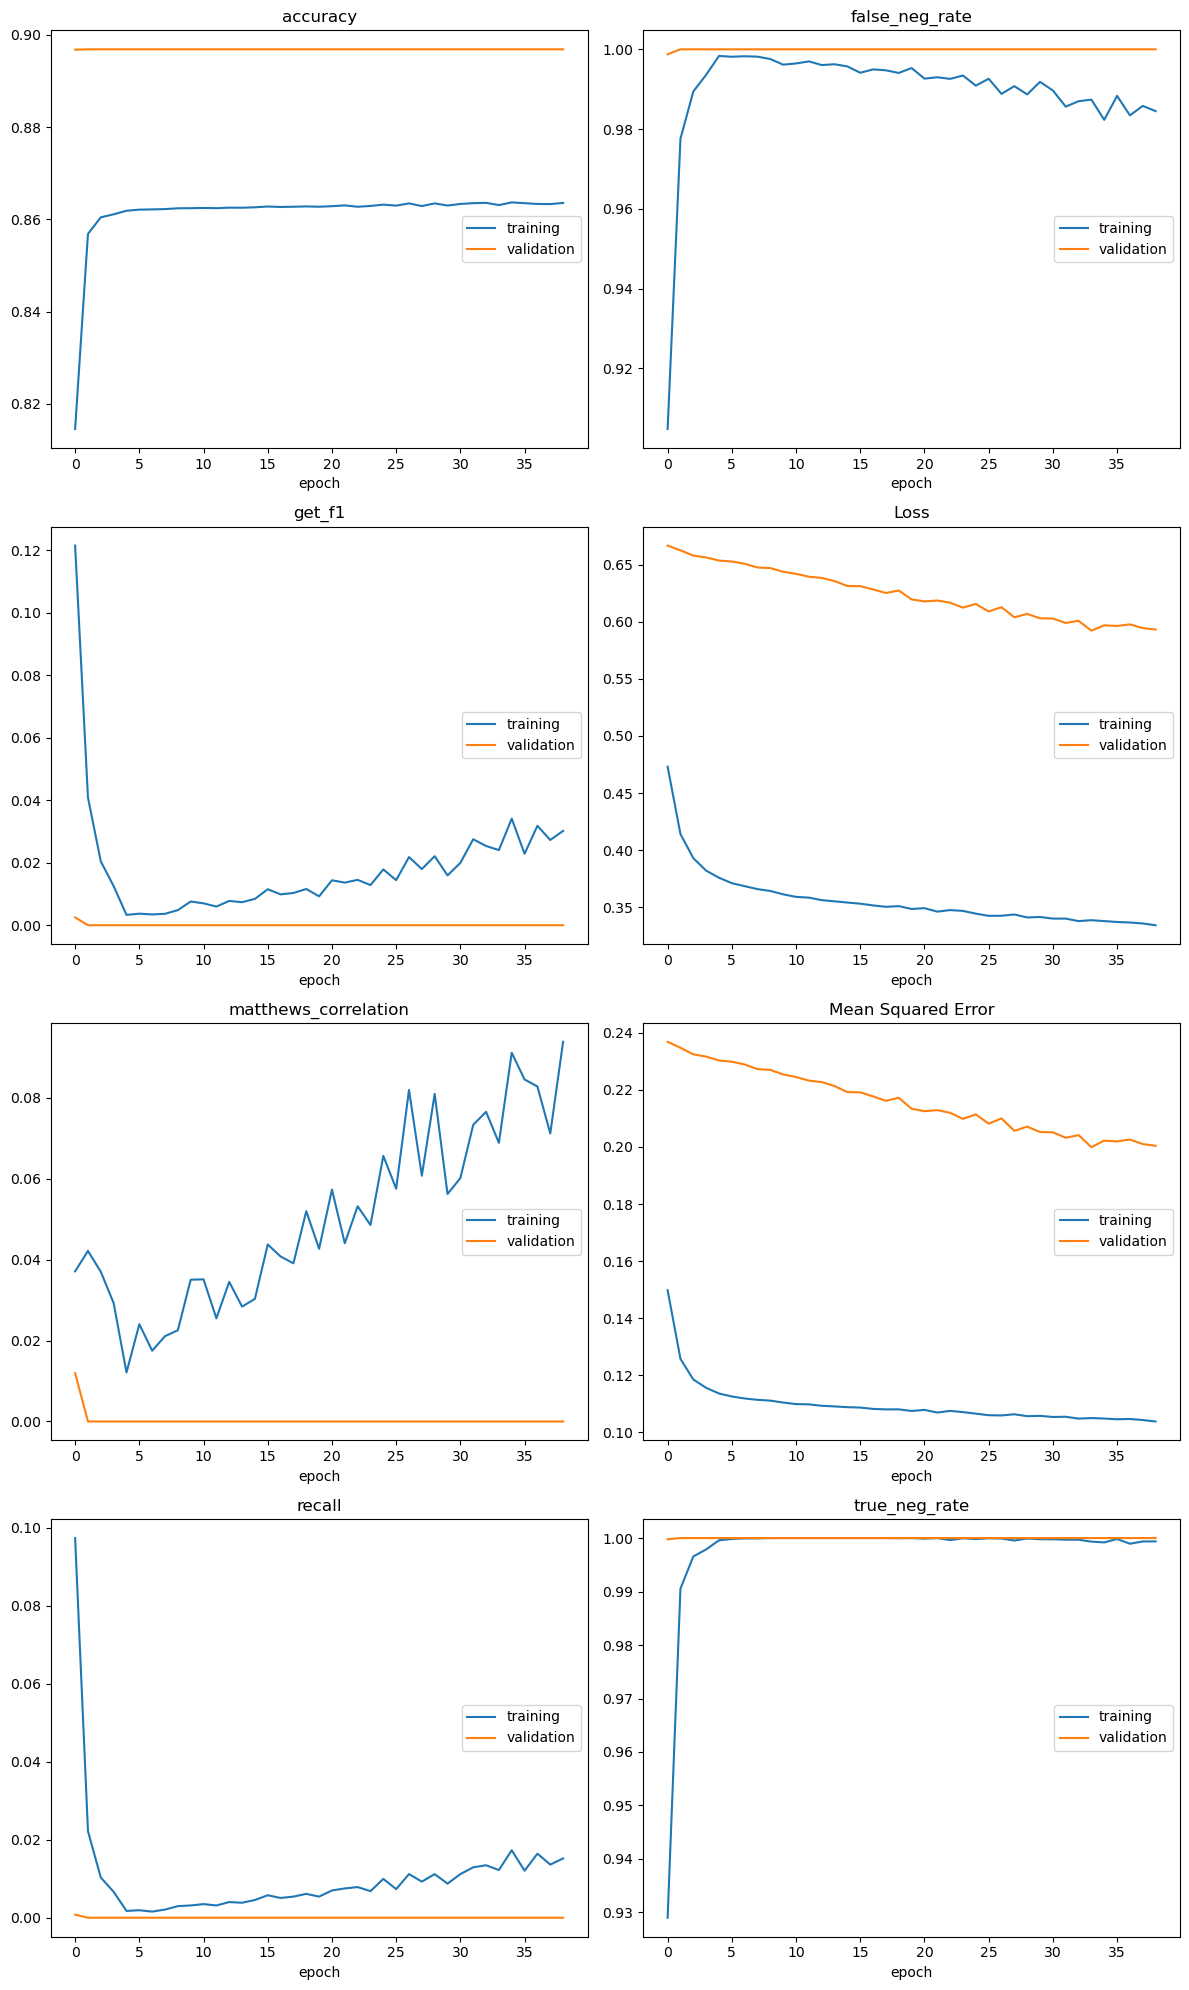

accuracy
	training         	 (min:    0.815, max:    0.864, cur:    0.864)
	validation       	 (min:    0.897, max:    0.897, cur:    0.897)
false_neg_rate
	training         	 (min:    0.905, max:    0.998, cur:    0.985)
	validation       	 (min:    0.999, max:    1.000, cur:    1.000)
get_f1
	training         	 (min:    0.003, max:    0.122, cur:    0.030)
	validation       	 (min:    0.000, max:    0.003, cur:    0.000)
Loss
	training         	 (min:    0.334, max:    0.473, cur:    0.334)
	validation       	 (min:    0.592, max:    0.667, cur:    0.593)
matthews_correlation
	training         	 (min:    0.012, max:    0.094, cur:    0.094)
	validation       	 (min:    0.000, max:    0.012, cur:    0.000)
Mean Squared Error
	training         	 (min:    0.104, max:    0.150, cur:    0.104)
	validation       	 (min:    0.200, max:    0.237, cur:    0.200)
recall
	training         	 (min:    0.002, max:    0.097, cur:    0.015)
	validation       	 (min:    0.000, max:    0.001, cur:    

In [37]:
%%time
n_samples = int(len(x_train)/BATCH_SIZE)*BATCH_SIZE
print(n_samples, len(x_train1_low))
#1: IR039, 3: IR108, 5: VIS006, 6: WV62
hist = model.fit(x = [x_train1_low[:n_samples], x_train3_low[:n_samples],  x_train5_low[:n_samples], x_train6_low[:n_samples]] , y = y_train_low[:n_samples],
          validation_data=([x_val1_low, x_val3_low, x_val5_low, x_val6_low], y_val_low),
                 batch_size=BATCH_SIZE, epochs=100,
                 shuffle=True,
                 verbose='auto',
                 callbacks=[early_stopping,
                     model_checkpoint_callback, 
                     PlotLossesKeras()
                    ])

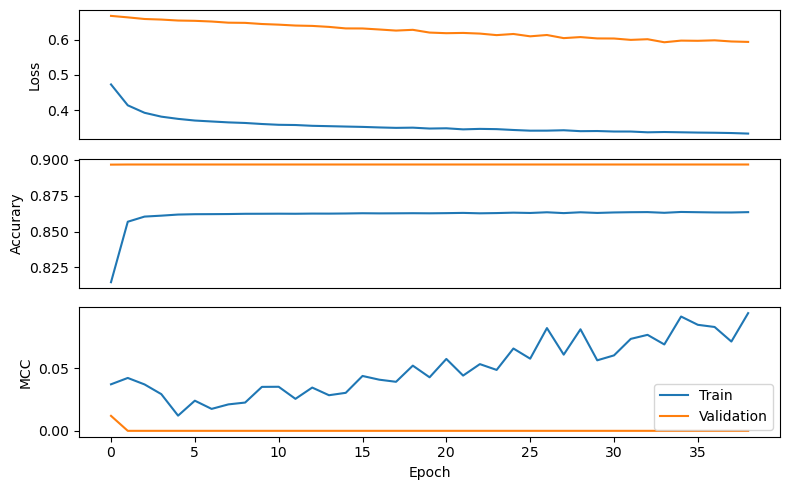

In [38]:
# summarize history for loss
fig,ax = plt.subplots(nrows=3, ncols=1, figsize=(8,5))
ax[0].plot(hist.history['loss'])
ax[0].plot(hist.history['val_loss'])
ax[0].set_ylabel('Loss')

# Acc
ax[1].plot(hist.history['accuracy'])
ax[1].plot(hist.history['val_accuracy'])
ax[1].set_ylabel('Accurary')

# MCC
ax[2].plot(hist.history['matthews_correlation'])
ax[2].plot(hist.history['val_matthews_correlation'])
ax[2].set_ylabel('MCC')
ax[2].set_xlabel('Epoch')
ax[2].legend(['Train', 'Validation'], loc='lower right')

#Figure adjustments
for j in range(0,2):
    ax[j].tick_params('both', labelbottom=False, bottom=False)
plt.subplots_adjust(wspace=0.0,hspace=0.0)
plt.tight_layout()
plt.show()